Павлова Татьяна

Face detector - OpenCV haar cascade

Face recognition model - Dlib

In [ ]:
!pip install deepface

     |████████████████████████████████| 61 kB 3.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 16.6 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=325b920840f1aec6c4bf02b092e5a6a0d10b3c92eab63485f062564d9dbe740d
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
backend = 'opencv'
model = "Dlib"


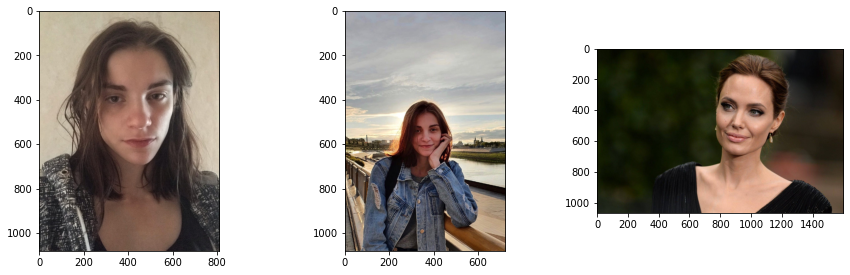

In [ ]:
img1 = cv2.imread('/content/drive/My Drive/me1.jpg')
img2 = cv2.imread('/content/drive/My Drive/me2.jpg')
img3 = cv2.imread('/content/drive/My Drive/Jolie.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
imgs = [img1,img2,img3]
plt.figure(figsize=[15, 15])
for i in range(0,3):
  plt.subplot(3, 3, i+1)
  plt.imshow(imgs[i])
plt.show()

In [ ]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img3_gray = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

Детектирование лица используя OpenCV haar cascade

In [ ]:
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces1 = face_cascade.detectMultiScale(img1_gray,1.3,5)
faces2 = face_cascade.detectMultiScale(img2_gray,1.3,5)
faces3 = face_cascade.detectMultiScale(img3_gray,1.3,5)

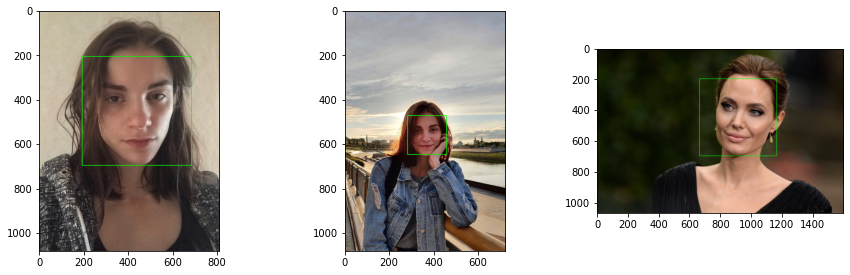

In [ ]:
for x, y, width, height in faces1:
    cv2.rectangle(img1, (x, y), (x + width, y + height), color=(0, 255, 0), thickness=2)
for x, y, width, height in faces2:
    cv2.rectangle(img2, (x, y), (x + width, y + height), color=(0, 255, 0), thickness=2)
for x, y, width, height in faces3:
    cv2.rectangle(img3, (x, y), (x + width, y + height), color=(0, 255, 0), thickness=2)
imgs = [img1,img2,img3]
plt.figure(figsize=[15, 15])
for i in range(0,3):
  plt.subplot(3, 3, i+1)
  plt.imshow(imgs[i])
plt.show()

In [ ]:
result = DeepFace.verify(img1, img2, distance_metric='euclidean', model_name = model, detector_backend = backend)
result

{'distance': 0.4712928788571035,
 'max_threshold_to_verify': 0.6,
 'model': 'Dlib',
 'similarity_metric': 'euclidean',
 'verified': True}

In [ ]:
result2 = DeepFace.verify(img1, img3,distance_metric='euclidean', model_name = model, detector_backend = backend)
result2

{'distance': 0.8216923337021709,
 'max_threshold_to_verify': 0.6,
 'model': 'Dlib',
 'similarity_metric': 'euclidean',
 'verified': False}

Верификация в реальном масштабе времени

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

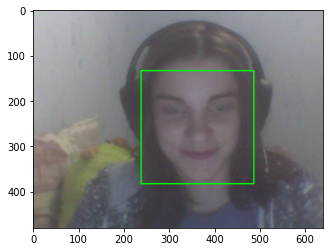

{'verified': True, 'distance': 0.4454750372978505, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


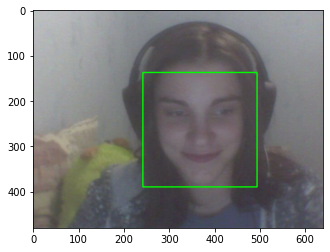

{'verified': True, 'distance': 0.45634885525771796, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


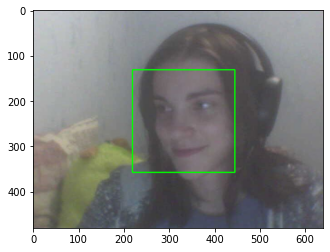

{'verified': True, 'distance': 0.5005087061101277, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


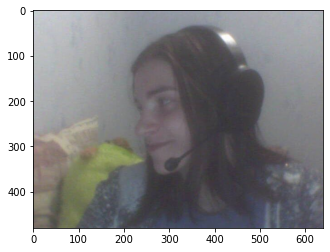

Лицо не найдено


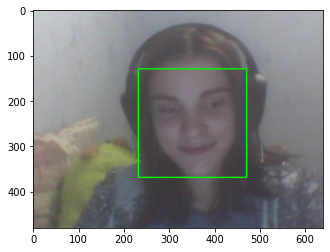

{'verified': True, 'distance': 0.4510564760927663, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


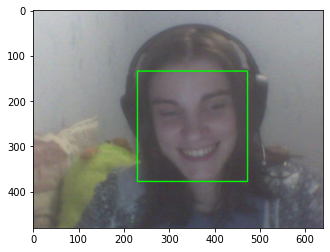

{'verified': True, 'distance': 0.4418419635378293, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


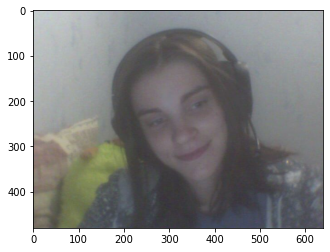

Лицо не найдено


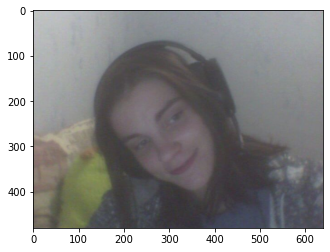

Лицо не найдено


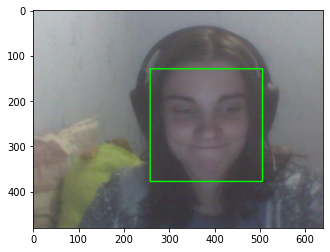

{'verified': True, 'distance': 0.43897154536420113, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


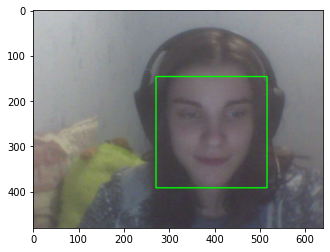

{'verified': True, 'distance': 0.3842647216565685, 'max_threshold_to_verify': 0.6, 'model': 'Dlib', 'similarity_metric': 'euclidean'}


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    try:
      result3 = DeepFace.verify(img1, image, distance_metric='euclidean', model_name = model, detector_backend = backend)
      for (x,y,w,h) in faces:
        image1 = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
      plt.imshow(image1)
      plt.show()
      print(result3)    
    except Exception as err:
      plt.imshow(image)
      plt.show()
      print("Лицо не найдено")